# YOOX Net-A-Porter - Technical Exercise

The purpose of this exercise is to try to identify customers at risk of lapse in order to take actoin before they stop to shop.
To pursue this objective, I'll be using 18 months of shopping history for a group of customers.

Information is split among two datasets: *account*, which contains data at customer level, and *transactions* which contains the transactions in the period.

### 1. Load and prepare data for the analysis

The first step consists in loading the two datasets and combining them together. The idea is to get a summarized view of what was the shopping history of every customer. I'll prepare two aggregations, one comprehensive of the whole period and one dividing each feature for every quarter available (18 months correspond to 6 quarters).

In [141]:
# importing libraries
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve
from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.externals import joblib
import xgboost as xgb

# data in .../ynap_data
data_path = os.path.join(os.getcwd(), 'ynap_data')
df_acc = pd.read_csv(os.path.join(data_path, 'account.csv'), sep=',')
df_trans = pd.read_csv(os.path.join(data_path, 'transactions.csv'), sep=',')

df_acc.head()

,customer_id,var3,var4,var5,var6,lapsed_next_period
0,553547,3.0,0.34,0.0,0.0,0
1,213578,3.0,0.11,0.0,0.0,0
2,906135,3.0,0.05,0.0,0.0,0
3,226782,2.0,0.01,0.0,0.0,0
4,103600,2.0,0.33,1.0,0.0,0


In [2]:
df_trans.head()

,customer_id,order_id,order_date,var1,var2,product_id,product_type_id,designer_id,gross_spend,net_spend
0,553547,235052,1989-08-28,0,0,96141,66,2262,1.304,1.304
1,553547,235052,1989-08-28,0,0,965607,44,2288,0.015,0.015
2,213578,335391,1990-09-02,1,0,13263,139,322,0.328,0.000
3,213578,50811,1990-11-23,1,0,596855,188,578,0.095,0.095
4,213578,50811,1990-11-23,1,0,779370,188,578,0.081,0.081


Let's check the size of the dataframes and if we have the same number of customers in the *account* and in the *transactions* dataframes:

In [3]:
# shape dataframes
print('account dataframe dimension: ({:,}, {:,})'.format(df_acc.shape[0], df_acc.shape[1]))
print('transactions dataframe dimension: ({:,}, {:,})'.format(df_trans.shape[0], df_trans.shape[1]))
print('customers in the transactions dataframe: {:,}'.format(df_trans['customer_id'].nunique()))

account dataframe dimension: (15,695, 6)
transactions dataframe dimension: (1,447,780, 10)
customers in the transactions dataframe: 15,695


Also, let's see how many lapsers there are in our data:

In [10]:
# chrun rate
print('Number of lapsers: {:,}'.format(df_acc['lapsed_next_period'].sum()))
print('Churn rate: {:.2%}'.format(df_acc['lapsed_next_period'].sum() / df_acc['customer_id'].nunique()))

Number of lapsers: 821
Churn rate: 5.23%


With the lapsers being only the 5.23% of the total, I can already figure out that a balance operation will be necessary, no matter the features I will be using in the modelling phase.

Before aggregating the data, I want to peform some engineering operations on certain variables in order to extract different informations from those. In this step I will use the *order date* to get the quarter of the transaction (which will be indicated with a concatenation of the year and the quarter of that year - i.e 198903 for the third quarter (July-September) of 1989).

Another operation will involve the peculiarity of *net spend*: we know that when it's set to zero the item of that transaction has been returned. By checking this we can understand whether an item has been returned or has been bought and kept.

In [11]:
df_trans['order_date'] = df_trans['order_date'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
df_trans['order_quarter'] = df_trans['order_date'].apply(
    lambda x: str(x.date().year) + str((x.date().month-1)//3+1).zfill(2))
df_trans['item_returned'] = df_trans['net_spend'].apply(lambda x: 1 if x == 0 else 0)
df_trans['item_bought'] = df_trans['net_spend'].apply(lambda x: 0 if x == 0 else 1)

Now we can aggregate the data.

Using the different aggregation operations I'll obtain the following metrics:
<li> By counting the unique values for *order_id*, *product_id*, *product_type_id*, *designer_id* I get the number of orders made by a customers, the number of products he ordered (not the quantity!), how many types of products he ordered and how many different designers are associated with the products he ordered (I would assume this as the brand of the product).
<li> I will sum the remaining features: *gross_spend*, *net_spend*, *item_bought*, *item_returned*. The sum of the spends will represent how much a customers has spent overall and after what he returned: this can lead to understand the *quote of spend he returned*. Instead, the sum of the item features are related to the quantity of prodcuts bought or returned.
<li> A different comment must be done on *var1* and *var2*. These are representing if some options have been activated or not at the moment of the shop (categorical feature 0/1). Since I'm getting an aggregated view of the different features, I can see what is the *quote of items bought with the option activated* by counting (summing) when the option has been activated over the total of items ordered in the period. Thus, I'm having as a result *quote_var1* and *quote_var2.
<li> Eventually these features can be combined together once more in order to get some average (relative) metrics of how the customers behaved in the period in exam. I've calculated: *net/gross spend per order*, *items bought/returned per order*, *average price for item bought and kept* (*ns_per_ib*) and *average price for item* (without distinctions, *gs_per_item*).

In [12]:
# column finder is a function that finds all the columns of a dataframe for a given substring
def column_finder(df, col, method=2):
    if method == 1:
        # method 1:
        cols_as_string = ' '.join(df.columns.values)
        cols_found = list(re.findall(col + '.*?\ ', cols_as_string))
        cols_found = [x.strip(' ') for x in cols_found]
    elif method == 2:
        # method 2:
        cols_found = []
        for col_elem in df.columns.values:
            if col in col_elem:
                cols_found.append(col_elem)
    else:
        raise ValueError
            
    return cols_found

# get_piv_counts_and_sums performs all the aggregations and the calculation of the average metrics
# if necessary, it performs a transposition of the table.
def get_piv_counts_and_sums(df, grouping_columns='customer_id'):
    
    dist_count_cols = ['order_id', 'product_id', 'product_type_id', 'designer_id']
    count_cols = ['var1', 'var2']
    sum_cols = ['gross_spend', 'net_spend', 'item_bought', 'item_returned', 'var1', 'var2']
    
    # maybe not necessary
    if type(grouping_columns) != list:
        glist = []
        glist.append(grouping_columns)
    else:
        glist = grouping_columns
   
    get_dist_counts = df.groupby(glist)[dist_count_cols].nunique().reset_index()
    get_counts = df.groupby(glist)[count_cols].count().reset_index()
    get_sums = df.groupby(glist)[sum_cols].sum().reset_index()
    get_sums = get_sums.rename(columns = {'var1': 'var1_sum', 'var2': 'var2_sum'})
    get_sums['quote_spend_returned'] = (get_sums['gross_spend'] - 
                                        get_sums['net_spend']) / get_sums['gross_spend']
    
    counts_and_sums = pd.merge(left=get_dist_counts, right=get_sums, how='inner', on=glist)
    counts_and_sums = pd.merge(left=counts_and_sums, right=get_counts, how='inner', on=glist)
    counts_and_sums['quote_var1'] = counts_and_sums['var1_sum'] / counts_and_sums['var1']
    counts_and_sums['quote_var2'] = counts_and_sums['var2_sum'] / counts_and_sums['var2']
    counts_and_sums.drop(['var1_sum', 'var1', 'var2_sum', 'var2'], axis=1, inplace=True)
    
    if len(glist) > 1:
        glist.pop(glist.index('customer_id'))
        if len(glist) == 1:
            glist = glist[0]
        
        cs_pivot = counts_and_sums.pivot(index='customer_id', columns=glist).fillna(0)
        csp_new_cols = []
        for col in cs_pivot.columns.get_values():
            csp_new_cols.append('_'.join(col))
                
        cs_pivot.columns = csp_new_cols
        cs_pivot = cs_pivot.reset_index()
        
        for val in counts_and_sums[glist].unique():
            #  relative metrics for time based tables
            cs_pivot['ns_per_order_' + str(val)] = cs_pivot['net_spend_' + str(val)] / cs_pivot['order_id_' + str(val)]
            cs_pivot['gs_per_order_' + str(val)] = cs_pivot['gross_spend_' + str(val)] / cs_pivot['order_id_' + str(val)]
            cs_pivot['ib_per_order_' + str(val)] = cs_pivot['item_bought_' + str(val)] / cs_pivot['order_id_' + str(val)]
            cs_pivot['ir_per_order_' + str(val)] = cs_pivot['item_returned_' + str(val)] / cs_pivot['order_id_' + str(val)]
            cs_pivot['ns_per_ib_' + str(val)] = cs_pivot['net_spend_' + str(val)] / cs_pivot['item_bought_' + str(val)]
            cs_pivot['gs_per_item_' + str(val)] = cs_pivot['gross_spend_' + str(val)] / (cs_pivot['item_bought_' + str(val)]
                                         + cs_pivot['item_returned_' + str(val)])
            
        return cs_pivot.fillna(0)
    
    else:
        # relative metrics for tot table
        counts_and_sums['ns_per_order'] = counts_and_sums['net_spend'] / counts_and_sums['order_id']
        counts_and_sums['gs_per_order'] = counts_and_sums['gross_spend'] / counts_and_sums['order_id']
        counts_and_sums['ib_per_order'] = counts_and_sums['item_bought'] / counts_and_sums['order_id']
        counts_and_sums['ir_per_order'] = counts_and_sums['item_returned'] / counts_and_sums['order_id']
        counts_and_sums['ns_per_ib'] = counts_and_sums['net_spend'] / counts_and_sums['item_bought']
        counts_and_sums['gs_per_item'] = counts_and_sums['gross_spend'] / (counts_and_sums['item_bought']
                          + counts_and_sums['item_returned'])
            
    return counts_and_sums.fillna(0)
            
tot_stats = get_piv_counts_and_sums(df_trans)
quarterly_stats = get_piv_counts_and_sums(df_trans, ['customer_id', 'order_quarter'])

Let's add these aggregation to the *account* dataframe and get our inputs for the model estimations.

In [98]:
# combining the account table with the aggregations
df_tot = pd.merge(left=df_acc, right=tot_stats, on='customer_id', how='inner')
df_qua = pd.merge(left=df_acc, right=quarterly_stats, on='customer_id', how='inner')

print('total aggregations dataframe dimension: ({:,}, {:,})'.format(df_tot.shape[0], df_tot.shape[1]))
print('quarterly aggregations dataframe dimension: ({:,}, {:,})'.format(df_qua.shape[0], df_qua.shape[1]))

# if necessary, here are the commands to output the dataframes just created
# df_tot.to_csv(os.path.join(data_path, 'df_tot.csv'), header=True, index=False)
# df_qua.to_csv(os.path.join(data_path, 'df_quarterly.csv'), header=True, index=False)

total aggregations dataframe dimension: (15,695, 23)
quarterly aggregations dataframe dimension: (15,695, 108)


Finally let's check the details of the dataframes

In [15]:
# no null values
df_tot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15695 entries, 0 to 15694
Data columns (total 23 columns):
customer_id             15695 non-null int64
var3                    15695 non-null float64
var4                    15695 non-null float64
var5                    15695 non-null float64
var6                    15695 non-null float64
lapsed_next_period      15695 non-null int64
order_id                15695 non-null int64
product_id              15695 non-null int64
product_type_id         15695 non-null int64
designer_id             15695 non-null int64
gross_spend             15695 non-null float64
net_spend               15695 non-null float64
item_bought             15695 non-null int64
item_returned           15695 non-null int64
quote_spend_returned    15695 non-null float64
quote_var1              15695 non-null float64
quote_var2              15695 non-null float64
ns_per_order            15695 non-null float64
gs_per_order            15695 non-null float64
ib_per_order  

In [83]:
# no null values here as well
sum(df_qua[df_qua.isnull()].count())

0

### 2. Exploratory analysis

In this step I'll try to gather as many information as possible from the features belonging to the dataframes.
I'll mainly consider the dataframe with the total aggregation beacuse of the less number of feature to examine. However, most of the considerations that will appear later can be translated to the quarterly dataframe.

Let's begin by describing the features and the type of variables they are:
<li>*customer_id*: id for the customer, not useful for the analysis
<li>*lapsed_next_period*: our response variable, we want to classify weather a customer will shop or not in the next period
<li>*var3*: customer segmentation, ordinal integer value from 0 to 3
<li>*var4*: customer segmentation, continuous feature from 0.0 to 0.8
<li>*var5*: customer segmentation, categorical feature (0, 1)
<li>*var6*: customer segmentation, categorical feature (0, 1)
<li>*order_id*: numerical feature, number of orders made by a customer in the period
<li>*product_id*: numerical feature, number of different prodcuts bought in the period
<li>*product_type_id*: numerical feature, number of different type of products bought in the period
<li>*designer_id*: numerical feature, number of different designers of the products bought in the period
<li>*gross_spend*: continuous feature, gross spend in the period
<li>*net_spend*: continuous feature, net spend in the period (gross spend - returned items)
<li>*item_bought*: numeical feature, item quantity in the period (not counting returned products)
<li>*item_returned*: numerical feature, items returned in the period
<li>*quote_spend_retuned*: percentage of spend returned over the gross spend in the period
<li>*quote_var1*: percentage of orders made with categorical feature var1 set to 1 in the period
<li>*quote_var2*: percentage of orders made with categorical feature var2 set to 1 in the period
<li>*ns_per_order*: continuous feature, average net spend per order in the period
<li>*gs_per_order*: continuous feature, average gross spend per order in the period
<li>*ib_per_order*: continuous feature, average items bought (and kept) per order in the period
<li>*ir_per_order*: continuous feature, average item returned per order in the period
<li>*ns_per_ib*: continuous feature, average net spend per item bought (and kept) in the period
<li>*gs_per_item*: continuous feature, average gross spend per item (no distinction between kept and returned) in the period

Unfortunately, there is no indication on the meaning of the customer segmentation features (except for a generic "shopping habits" description in each one of those), so it's proven hard to understand what type of relation/explanation they have on the customer behaviour.

I can assume that higher values could mean "good" for the customers and viceversa for lower values. If it's really the case, then I should expect higher proportion of lapsers when the values are low. But again, this can be true for *var3* (assuming that the numbers are representing an order) and *var4* and maybe not for *var5* and *var6* as they are a simple dichotomy 0/1.

Let's compute the "correlations" before transforming the features from numbers to factors.

In [27]:
df_tot[['var3','var4','var5','var6','lapsed_next_period']].corr()['lapsed_next_period']

var3                 -0.049122
var4                  0.028221
var5                 -0.049656
var6                 -0.026682
lapsed_next_period    1.000000
Name: lapsed_next_period, dtype: float64

If there are some orders in the segmentations, these are not evident in a relation with the response variable.

Next, I'll transform the features in factors (categories in Python) and plot some distribution charts.

In [33]:
# transformation to factors
df_tot['var3'] = df_tot['var3'].astype('category')
df_tot['var5'] = df_tot['var5'].astype('category')
df_tot['var6'] = df_tot['var6'].astype('category')

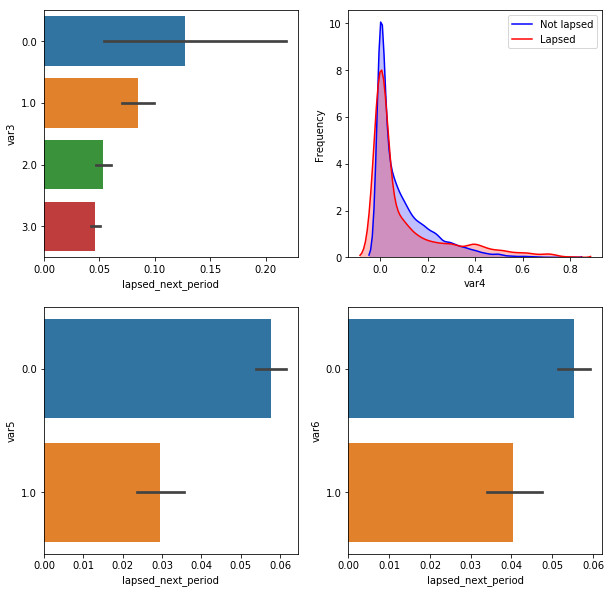

In [37]:
# function to plot a distribution chart
# dataframes divided by lapsed and not lapsed customers
lapsed = df_tot[df_tot['lapsed_next_period'] == 1]
nolapsed = df_tot[df_tot['lapsed_next_period'] == 0]
lapsed_col = 'red'
nolapsed_col = 'blue'

def kde_plot(var, df, y='lapsed_next_period', colors=[lapsed_col, nolapsed_col]):
    g = sns.kdeplot(df[var][df[y] == 0], color=colors[1], shade = True)
    g = sns.kdeplot(df[var][df[y] == 1], ax =g, color=colors[0], shade= True)
    g.set_xlabel(var)
    g.set_ylabel("Frequency")
    g = g.legend(["Not lapsed","Lapsed"])

plt.figure(figsize=[10,10])
plt.subplot(221)
sns.barplot(y='var3', x='lapsed_next_period', data=df_tot)
plt.subplot(222)
kde_plot('var4', df=df_tot)

plt.subplot(223)
sns.barplot(y='var5', x='lapsed_next_period', data=df_tot)
plt.subplot(224)
sns.barplot(y='var6', x='lapsed_next_period', data=df_tot)

It looks like that lower values for *var3, var5* and *var6* are associated with a (slightly) higher percentage of lapsers, while we can conclude the opposite for *var4*, although the differences are not extremely evident. *var3* seems to have a clearer indication, but the error bar for the label "0" is quite wide.

Let's now have a look to the numerical features.

In [41]:
pd.set_option('display.max_columns', df_tot.shape[1])
df_tot.drop(['customer_id', 'lapsed_next_period'], axis=1).describe(percentiles=[.25, .5, .75, .9, .95, .99])

,var4,order_id,product_id,product_type_id,designer_id,gross_spend,net_spend,item_bought,item_returned,quote_spend_returned,quote_var1,quote_var2,ns_per_order,gs_per_order,ib_per_order,ir_per_order,ns_per_ib,gs_per_item
count,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000,15695.000000
mean,0.090337,28.069067,82.289137,17.939153,42.425932,62.900750,37.026920,65.451163,26.793501,0.287259,0.056155,0.363912,1.681839,2.536846,2.834274,0.883410,0.668971,0.744785
std,0.119589,36.043604,107.600136,10.820396,38.245974,112.168475,67.195427,96.340882,60.020291,0.261323,0.151469,0.380702,2.007964,2.745275,2.721017,1.439865,0.555821,0.584133
min,0.000000,1.000000,1.000000,1.000000,1.000000,0.022000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.022000,0.000000,0.000000,0.000000,0.022000
25%,0.000000,8.000000,22.000000,10.000000,15.000000,15.478000,11.053500,18.000000,1.000000,0.030079,0.000000,0.000000,0.740131,1.157664,1.333333,0.066667,0.388535,0.441396
50%,0.040000,18.000000,52.000000,17.000000,33.000000,33.425000,22.422000,41.000000,7.000000,0.237215,0.000000,0.205882,1.194000,1.842905,2.090909,0.452830,0.554713,0.627385
75%,0.140000,35.000000,102.000000,25.000000,58.000000,68.482000,40.728500,79.000000,27.000000,0.488026,0.014260,0.733333,1.976784,2.989751,3.400000,1.111111,0.794922,0.891230
90%,0.260000,63.000000,181.000000,33.000000,90.000000,138.121600,75.320800,141.000000,70.000000,0.674104,0.189414,1.000000,3.222347,4.815071,5.400000,2.166667,1.141441,1.251898
95%,0.350000,87.000000,257.300000,38.000000,116.000000,207.375200,114.834500,200.000000,115.000000,0.768307,0.355464,1.000000,4.461890,6.645919,7.160526,3.192680,1.451111,1.582519
99%,0.500000,160.060000,519.060000,48.000000,180.000000,505.224060,258.829500,419.000000,269.000000,0.897804,0.848233,1.000000,8.619950,12.438479,13.000000,6.500000,2.500133,2.626973


At a first glance, my features seem to be really skewed.

In [42]:
df_skew = df_tot.drop(['customer_id', 'lapsed_next_period'], axis=1).skew(axis=0)
print(df_skew)

var3                    -1.171049
var4                     1.774775
var5                     1.591724
var6                     1.499148
order_id                 8.300763
product_id               5.132884
product_type_id          0.695625
designer_id              2.108079
gross_spend              9.154562
net_spend               14.485596
item_bought              8.609743
item_returned            7.970509
quote_spend_returned     0.583152
quote_var1               3.806513
quote_var2               0.565288
ns_per_order            11.484365
gs_per_order             7.858432
ib_per_order             6.163338
ir_per_order             5.905353
ns_per_ib               10.852314
gs_per_item              9.827490
dtype: float64


As expected, many of these numerical features are skewed, mainly due to the range of values these features show. If I keep these variables as they are, I can end up having a strong bias in my estimation phase because of few big values.

Since these features show a huge increase in the very last percentiles, I'll try to use a BoxCox transformation to linearize the distribution. The transformation will be applied in the form of y = log(x + a), where a > 0 and where a feature has an absolute skewness greater than 1.

In [44]:
# apply a log transformation
def boxcox_func(x, l=1):
    return np.log(x + l)

def boxcox_trans(df, var_list):
    for var in var_list:
        if df[var].max() <= 1:
            df[var] = df[var].apply(boxcox_func, l=0.001)
        else:
            df[var] = df[var].apply(boxcox_func)
    return df

idx = np.where((df_skew > 1) | (df_skew < - 1))[0]
skewed_cols = list(df_skew.iloc[idx].index.values)
skewed_cols = [x for x in skewed_cols if x not in ['lapsed_next_period', 'var3', 'var5', 'var6']] #
df_tot_log = boxcox_trans(df_tot, skewed_cols)

df_tot_log.drop(['customer_id', 'lapsed_next_period'], axis=1).skew(axis=0)

var3                   -1.171049
var4                   -0.310157
var5                    1.591724
var6                    1.499148
order_id               -0.112957
product_id             -0.433412
product_type_id         0.695625
designer_id            -0.606685
gross_spend            -0.206408
net_spend              -0.247246
item_bought            -0.388819
item_returned           0.216270
quote_spend_returned    0.583152
quote_var1              1.292020
quote_var2              0.565288
ns_per_order            1.226928
gs_per_order            1.011391
ib_per_order            0.888243
ir_per_order            1.275263
ns_per_ib               1.719303
gs_per_item             1.601411
dtype: float64

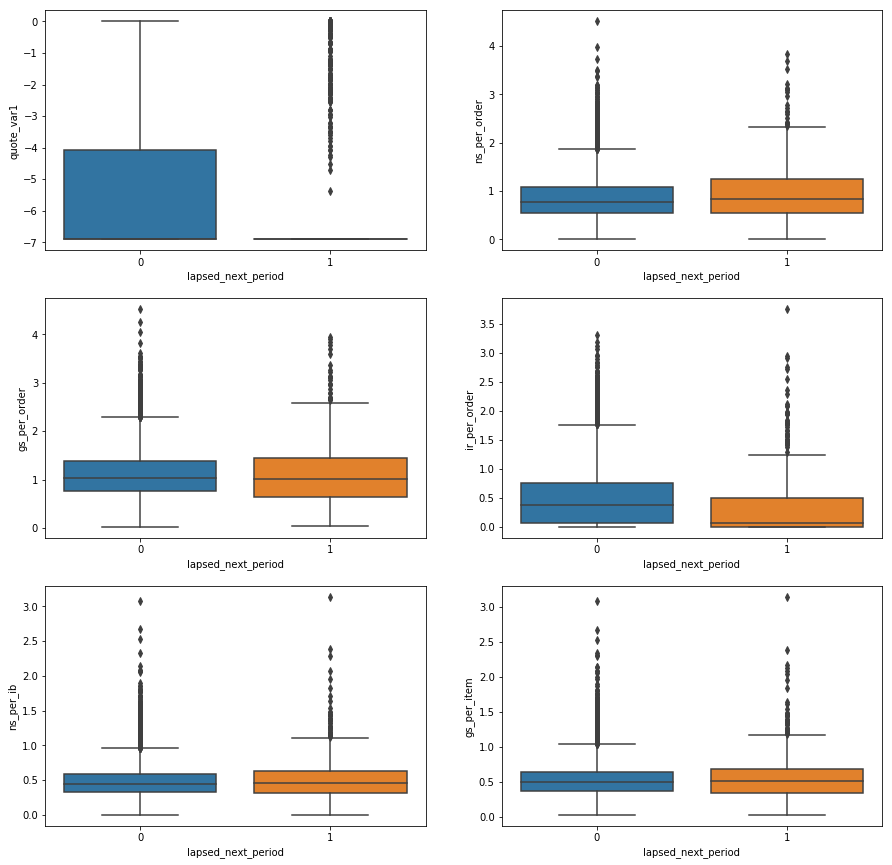

In [45]:
# some variables are still skewed, let's have a look to the boxplots
plt.figure(figsize=[15,15])
plt.subplot(321)
sns.boxplot(y='quote_var1', x='lapsed_next_period', data=df_tot_log)

plt.subplot(322)
sns.boxplot(y='ns_per_order', x='lapsed_next_period', data=df_tot_log)

plt.subplot(323)
sns.boxplot(y='gs_per_order', x='lapsed_next_period', data=df_tot_log)

plt.subplot(324)
sns.boxplot(y='ir_per_order', x='lapsed_next_period', data=df_tot_log)

plt.subplot(325)
sns.boxplot(y='ns_per_ib', x='lapsed_next_period', data=df_tot_log)

plt.subplot(326)
sns.boxplot(y='gs_per_item', x='lapsed_next_period', data=df_tot_log)

Some features are still skewed, but now we can check for outliers and eventually remove them from the dataframe.

We can use the same rule that is applied to the boxplots above. We compute the interquartile range (IQR) and consider an outlier everything that is out of the interval [q1 - 1.5 \* IQR; q3 + 1.5 \* IQR], where q1 and q3 are the first quartile and the third quartile respectvely.

In [47]:
# outlier detection for continuous variables, using the seaborn standard (1.5 * IQR)
def get_outlier_indexes(df, var):
    q3 = df[var].quantile(0.75) 
    q1 = df[var].quantile(0.25)
    iqr = q3 - q1
    idx = df[(df[var] < q1 - (1.5 * iqr)) | (df[var] > q3 + (1.5 * iqr))].index.values
    #print(idx.shape)
    return idx

def outlier_detector(df, var_list):
    out_idx = np.ndarray(0)
    for var in var_list:
        var_out_idx = get_outlier_indexes(df, var)
        out_idx = np.unique(np.concatenate((out_idx, var_out_idx)))
    return out_idx

outindex = outlier_detector(df_tot_log, ['quote_var1', 'ns_per_order', 'gs_per_order', 'ir_per_order',
                                         'ns_per_ib', 'gs_per_item'])

df_check_outl = df_tot_log.iloc[outindex]
c_ol = df_check_outl[df_check_outl['lapsed_next_period'] == 1]
nc_ol = df_check_outl[df_check_outl['lapsed_next_period'] == 0]

print('Outliers detected: {:,}'.format(outindex.shape[0]))
print('Outliers in the lapsed group: {:,}'.format(c_ol.shape[0]))
print('Outliers in the non lapsed group: {:,}'.format(nc_ol.shape[0]))
print('')
print('Outlier proportion in the lapsed group: {:.2%}'.format(c_ol.shape[0]/lapsed.shape[0]))
print('Outlier proportion in the non lapsed group: {:.2%}'.format(nc_ol.shape[0]/nolapsed.shape[0]))

Outliers detected: 1,406
Outliers in the lapsed group: 145
Outliers in the non lapsed group: 1,261

Outlier proportion in the lapsed group: 17.66%
Outlier proportion in the non lapsed group: 8.48%


Removing the outliers means that the 18% of my lapsed data will be removed as well, and probably it's an exceeding quantity. Before taking a final decision, let's have compare the features from the 2 dataframes (with outliers/without outliers) with some plots.

In [49]:
df_tot_log_noout = df_tot_log.drop(df_tot_log.index[df_check_outl.index.values], axis=0)
print('log-transformed dataframe with outliers dimension: ({:,}, {:,})'.format(df_tot_log.shape[0], df_tot_log.shape[1]))
print('log-transformed dataframe without outliers dimension: ({:,}, {:,})'.format(
    df_tot_log_noout.shape[0], df_tot_log_noout.shape[1]))

log-transformed dataframe with outliers dimension: (15,695, 23)
log-transformed dataframe without outliers dimension: (14,289, 23)


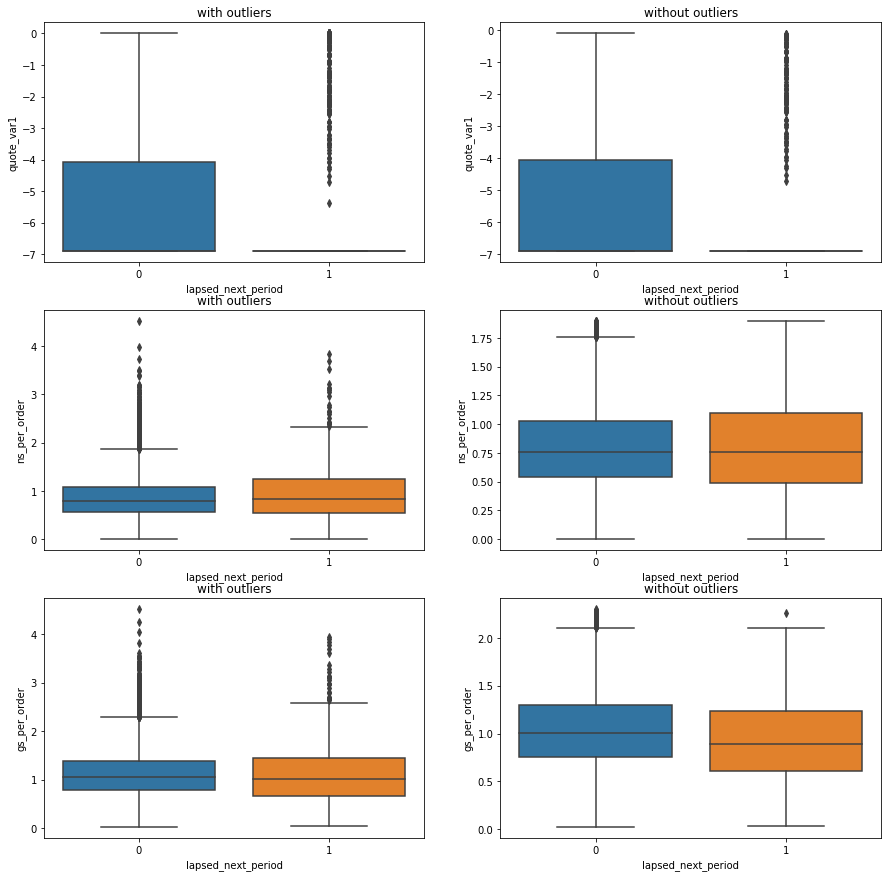

In [56]:
# boxplot comparisons after removing outliers
plt.figure(figsize=[15,15])
plt.subplot(321)
sns.boxplot(y='quote_var1', x='lapsed_next_period', data=df_tot_log)
plt.title('with outliers')

plt.subplot(322)
sns.boxplot(y='quote_var1', x='lapsed_next_period', data=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(323)
sns.boxplot(y='ns_per_order', x='lapsed_next_period', data=df_tot_log)
plt.title('with outliers')

plt.subplot(324)
sns.boxplot(y='ns_per_order', x='lapsed_next_period', data=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(325)
sns.boxplot(y='gs_per_order', x='lapsed_next_period', data=df_tot_log)
plt.title('with outliers')

plt.subplot(326)
sns.boxplot(y='gs_per_order', x='lapsed_next_period', data=df_tot_log_noout)
plt.title('without outliers')

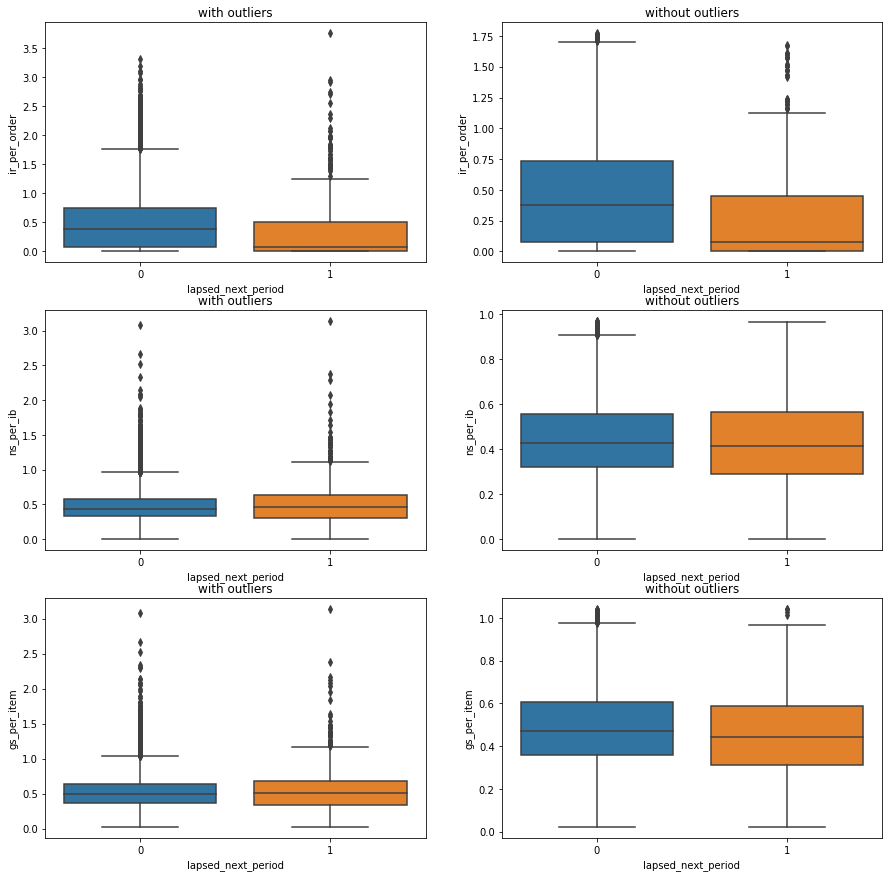

In [57]:
# boxplot comparisons after removing outliers
# part 2
plt.figure(figsize=[15,15])
plt.subplot(321)
sns.boxplot(y='ir_per_order', x='lapsed_next_period', data=df_tot_log)
plt.title('with outliers')

plt.subplot(322)
sns.boxplot(y='ir_per_order', x='lapsed_next_period', data=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(323)
sns.boxplot(y='ns_per_ib', x='lapsed_next_period', data=df_tot_log)
plt.title('with outliers')

plt.subplot(324)
sns.boxplot(y='ns_per_ib', x='lapsed_next_period', data=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(325)
sns.boxplot(y='gs_per_item', x='lapsed_next_period', data=df_tot_log)
plt.title('with outliers')

plt.subplot(326)
sns.boxplot(y='gs_per_item', x='lapsed_next_period', data=df_tot_log_noout)
plt.title('without outliers')

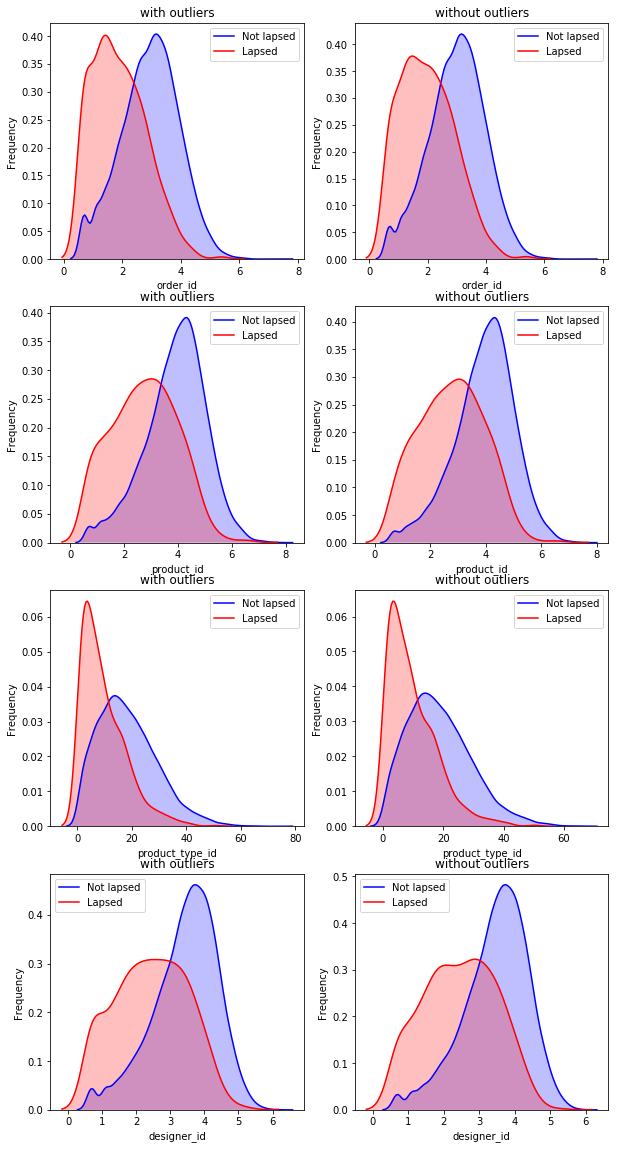

In [58]:
# boxplot comparisons after removing outliers
# part 3
plt.figure(figsize=[10,20])
plt.subplot(421)
kde_plot('order_id', df=df_tot_log)
plt.title('with outliers')
plt.subplot(422)
kde_plot('order_id', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(423)
kde_plot('product_id', df=df_tot_log)
plt.title('with outliers')
plt.subplot(424)
kde_plot('product_id', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(425)
kde_plot('product_type_id', df=df_tot_log)
plt.title('with outliers')
plt.subplot(426)
kde_plot('product_type_id', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(427)
kde_plot('designer_id', df=df_tot_log)
plt.title('with outliers')
plt.subplot(428)
kde_plot('designer_id', df=df_tot_log_noout)
plt.title('without outliers')

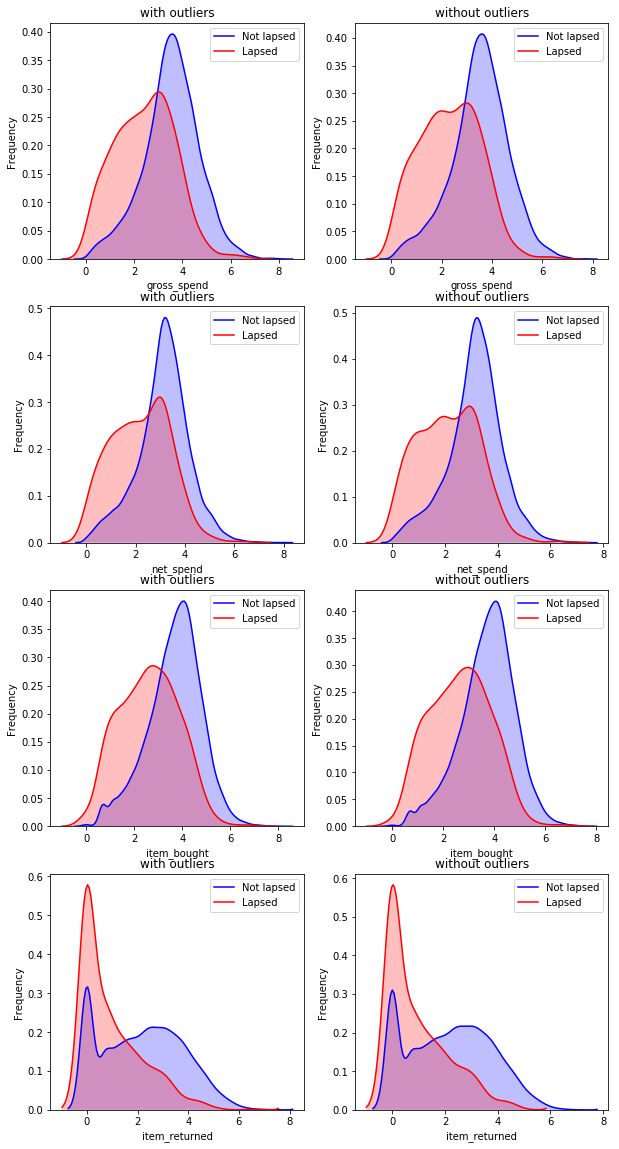

In [59]:
plt.figure(figsize=[10,20])
plt.subplot(421)
kde_plot('gross_spend', df=df_tot_log)
plt.title('with outliers')
plt.subplot(422)
kde_plot('gross_spend', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(423)
kde_plot('net_spend', df=df_tot_log)
plt.title('with outliers')
plt.subplot(424)
kde_plot('net_spend', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(425)
kde_plot('item_bought', df=df_tot_log)
plt.title('with outliers')
plt.subplot(426)
kde_plot('item_bought', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(427)
kde_plot('item_returned', df=df_tot_log)
plt.title('with outliers')
plt.subplot(428)
kde_plot('item_returned', df=df_tot_log_noout)
plt.title('without outliers')

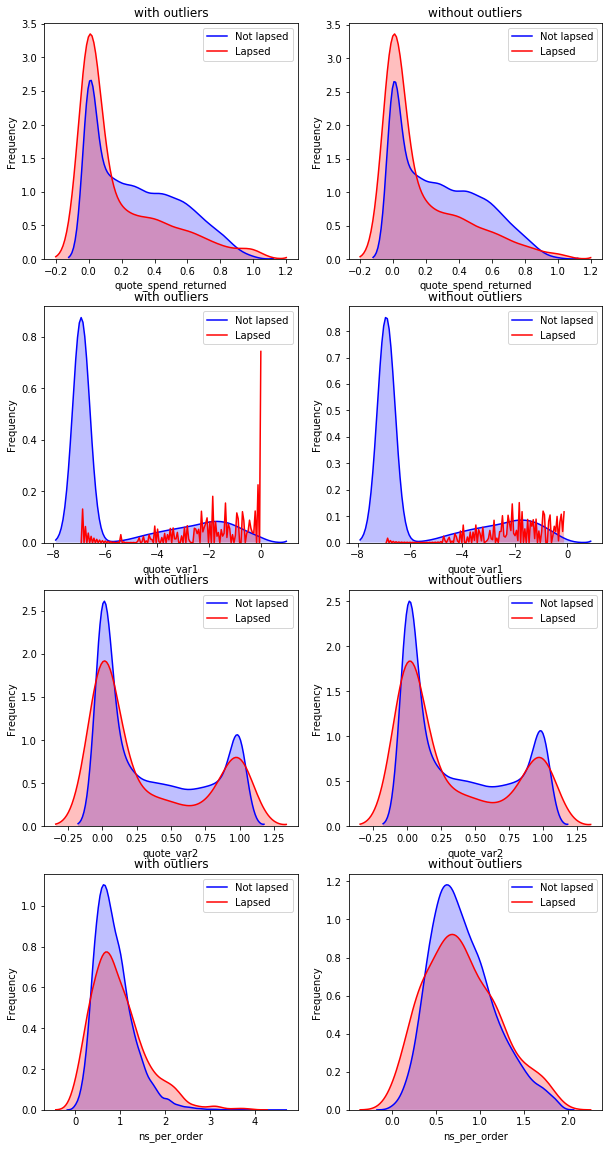

In [60]:
plt.figure(figsize=[10,20])
plt.subplot(421)
kde_plot('quote_spend_returned', df=df_tot_log)
plt.title('with outliers')
plt.subplot(422)
kde_plot('quote_spend_returned', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(423)
kde_plot('quote_var1', df=df_tot_log)
plt.title('with outliers')
plt.subplot(424)
kde_plot('quote_var1', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(425)
kde_plot('quote_var2', df=df_tot_log)
plt.title('with outliers')
plt.subplot(426)
kde_plot('quote_var2', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(427)
kde_plot('ns_per_order', df=df_tot_log)
plt.title('with outliers')
plt.subplot(428)
kde_plot('ns_per_order', df=df_tot_log_noout)
plt.title('without outliers')

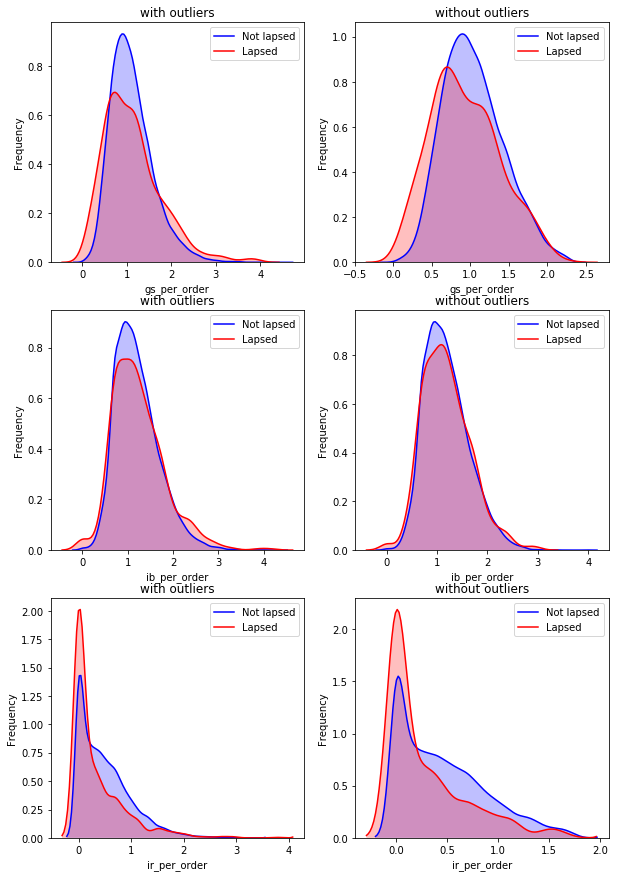

In [61]:
plt.figure(figsize=[10,15])
plt.subplot(321)
kde_plot('gs_per_order', df=df_tot_log)
plt.title('with outliers')
plt.subplot(322)
kde_plot('gs_per_order', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(323)
kde_plot('ib_per_order', df=df_tot_log)
plt.title('with outliers')
plt.subplot(324)
kde_plot('ib_per_order', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(325)
kde_plot('ir_per_order', df=df_tot_log)
plt.title('with outliers')
plt.subplot(326)
kde_plot('ir_per_order', df=df_tot_log_noout)
plt.title('without outliers')

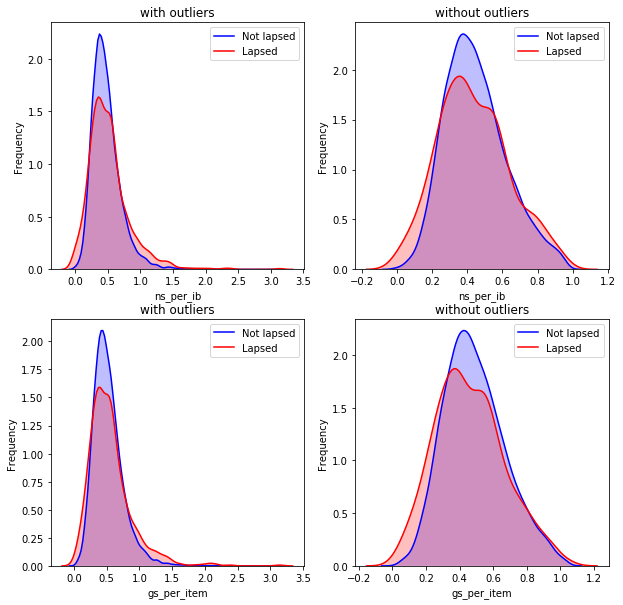

In [62]:
plt.figure(figsize=[10,10])
plt.subplot(221)
kde_plot('ns_per_ib', df=df_tot_log)
plt.title('with outliers')
plt.subplot(222)
kde_plot('ns_per_ib', df=df_tot_log_noout)
plt.title('without outliers')

plt.subplot(223)
kde_plot('gs_per_item', df=df_tot_log)
plt.title('with outliers')
plt.subplot(224)
kde_plot('gs_per_item', df=df_tot_log_noout)
plt.title('without outliers')

After plotting and having a look to all the distributions of the features, I can write down a couple of comments:
<li>removing the outliers doesn't change dramatically the effect of the features on the churn behaviour (but shows better distributions for several features)
<li>some numerical features have a clear indication of whether high (or low) values could have an association with churn behaviour: *order_id, product_id, product_type_id, designer_id, gross_spend, net_spend, item_bought, item_returned, quote_spend_returned, ir_per_order*. (but what will happen after balancing?)

Let's have a look to the correlation matrix for a confirmation of what written.

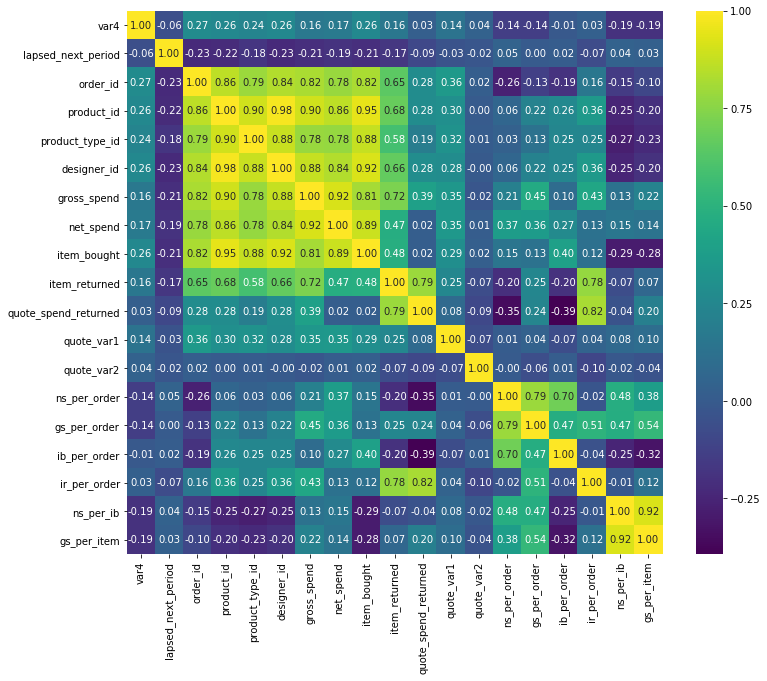

In [63]:
# log transformation with outliers
fig, ax = plt.subplots(figsize=(12,10))
g = sns.heatmap(df_tot_log.drop('customer_id', axis=1).corr(), annot=True,
                fmt=".2f", cmap='viridis', ax=ax)

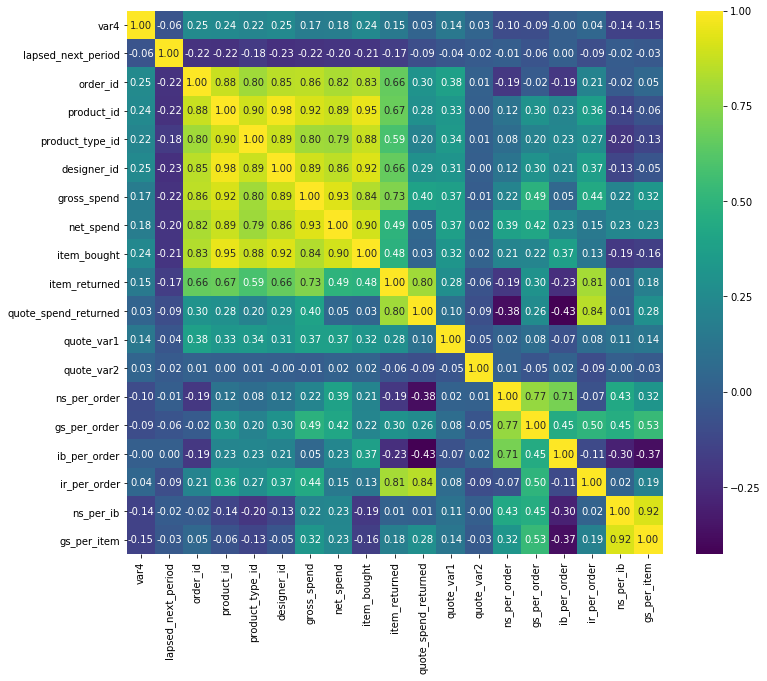

In [64]:
# log transformation without outliers
fig, ax = plt.subplots(figsize=(12,10))
g = sns.heatmap(df_tot_log_noout.drop('customer_id', axis=1).corr(), annot=True,
                fmt=".2f", cmap='viridis', ax=ax)

There is a cluster of highly correlated features, mainly because of the nature of the transactions. 
Also, the relative metrics are sharing high correlations between them, so probably not everything will be necessary for the model.
Finally, not much seems correlated with *lapsed_next_period*.

I could try to run the same exploratory analysis after a balancing operation. The balancing won't have a separation between train set and test set because the idea is just to understand how variables are related between each other.

In [66]:
# function for a quick balancing operation
def fast_balancer(df, y='lapsed_next_period'):
    df0 = df[df[y] == 0]
    df1 = df[df[y] == 1]
    df0_ = df0.sample(n=df1.shape[0], random_state=101)
    df_ = df0_.append(df1)
    print("dimension of the balanced dataframe: ({:,}, {:,})".format(df_.shape[0], df_.shape[1]))
    return df_

df_tot_log_ = fast_balancer(df_tot_log)
df_tot_log_noout_ = fast_balancer(df_tot_log_noout)

dimension of the balanced dataframe: (1,642, 23)
dimension of the balanced dataframe: (1,352, 23)


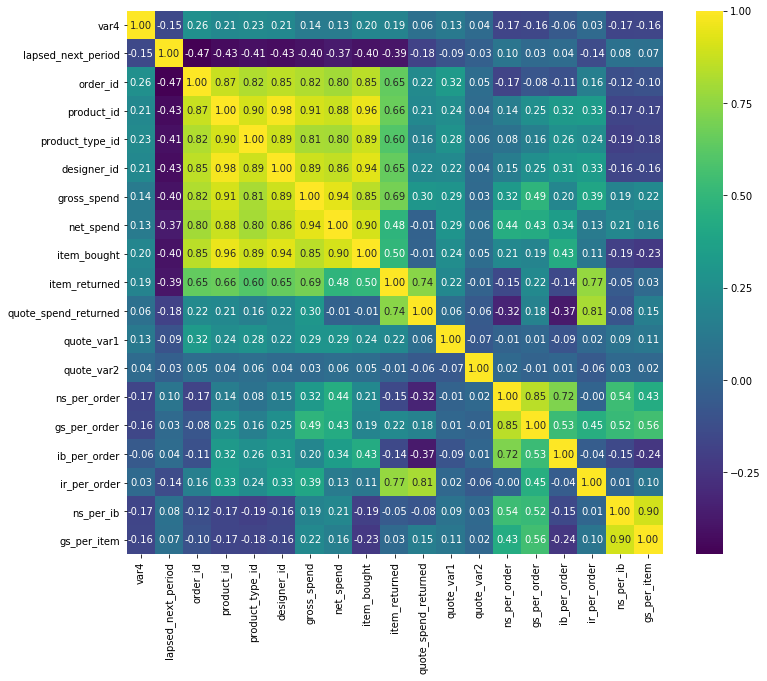

In [67]:
# log transformed dataframe with outliers (after balancing)
fig, ax = plt.subplots(figsize=(12,10))
g = sns.heatmap(df_tot_log_.drop('customer_id', axis=1).corr(), annot=True,
                fmt=".2f", cmap='viridis', ax=ax)

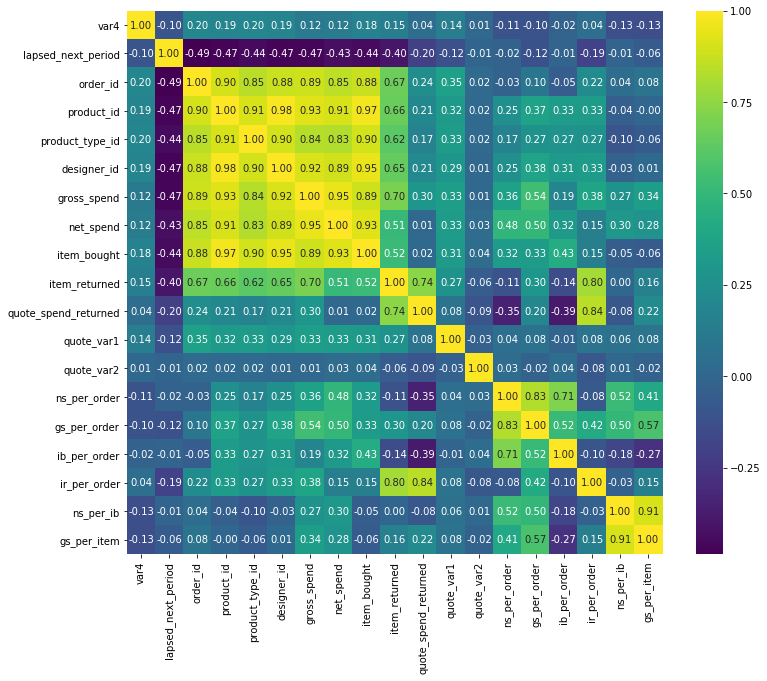

In [68]:
# log transformed dataframe without outliers (after balancing)
fig, ax = plt.subplots(figsize=(12,10))
g = sns.heatmap(df_tot_log_noout_.drop('customer_id', axis=1).corr(), annot=True,
                fmt=".2f", cmap='viridis', ax=ax)

The cluster of transactional metrics and the one of relative metrics are even more correlated after the balancing operation:
<li> *product_id, product_type_id* and *designer_id* are essentialy telling us the same thing, which is the grade of range of products bought by the customers. We'll keep *product_type_id* which appaear to be (very slightly) less correlated with the rest of features.
<li> We can choose only one between *gross_spend* and *net_spend*. We'll keep the latter and make sure we keep also something to measure what customers have returned.
<li> *item_bought* and *item_returned* are really correlated with spend and *quote_spend_returned*, we can remove both and keep *net_spend* and *quote_spend_returned*
<li> We'll keep *gs_per_order* over *ns_per_order* in order to estimate the average spend at the moment of buy
<li> Since we have *quote_spend_returned* as "return measure" we can drop *ir_per_order*
<li> Finally let's keep only one "spend per item" (average price) feature, *ns_per_ib*

I didn't want to remove *order_id* because otherwise I would have missed a measure for the visits.

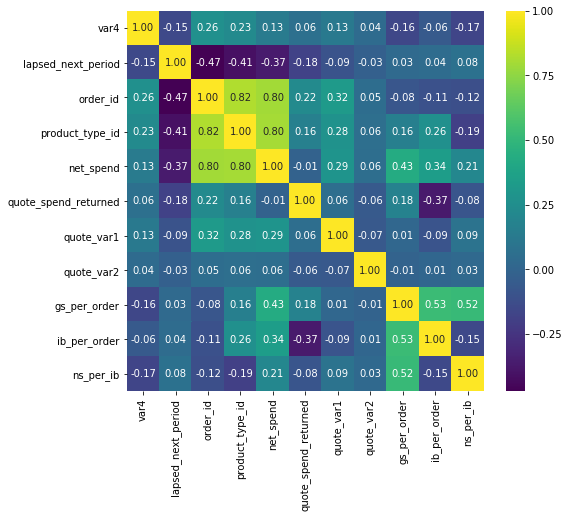

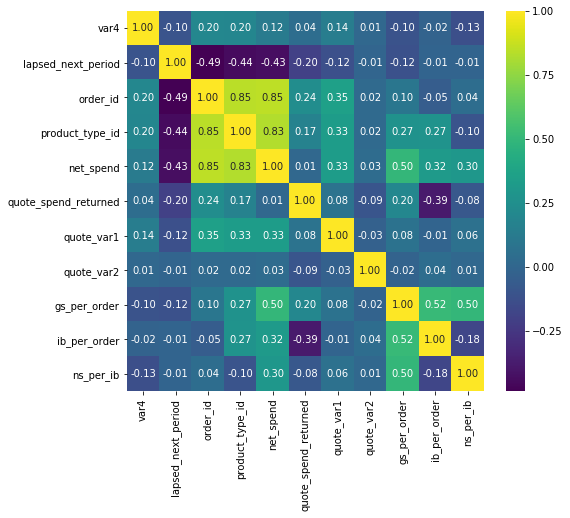

In [73]:
# helper to find the columns on a dataframe and remove them
def column_remover(df, col_list, noprint=False):    
    if type(col_list) != list:
        cl = []
        cl.append(col_list)
        col_list =cl
    
    col_to_remove = []
    for col in col_list:
        #print(col)
        col_to_remove.extend(column_finder(df, col, method=2))
    
    df.drop(col_to_remove, axis=1, inplace=True)
    if not noprint:
        print(col_to_remove)
        
        
columns_to_remove = ['product_id', 'designer_id', 'gross_spend', 'item_bought', 'item_returned',
                                'ns_per_order', 'ir_per_order', 'gs_per_item']

column_remover(df_tot_log_, columns_to_remove, noprint=True)
column_remover(df_tot_log_noout_, columns_to_remove, noprint=True)

fig, ax = plt.subplots(figsize=(8,7))
g = sns.heatmap(df_tot_log_.drop('customer_id', axis=1).corr(), annot=True,
                fmt=".2f", cmap='viridis', ax=ax)
fig, ax = plt.subplots(figsize=(8,7))
g = sns.heatmap(df_tot_log_noout_.drop('customer_id', axis=1).corr(), annot=True,
                fmt=".2f", cmap='viridis', ax=ax)

Now we are on a better situation: there are not correlation between potentials predictors (except fot the green cluster of *orders*, *product_types* and *net_spend*) and there are a slightly more correlated features with the response variable.
This will be convinient once I'll perform the real separation between train set and test set.

The log-transformed variabiles seem to work better, so I will definitely use those in the model phase. Also, removing the outliers seems to be beneficial, since it has normalized many feature distributions and therefore I'll move on with the no-outlier data.

However, one disadvantage of using the data aggregated at a total level (18 months) is that we won't consider the time of the transactions. It's unlikely that a customers have decided to become a lapser long before the end of the period.

One possibility is the estimation of the model using the data at a quarterly level. To extremize the concept even more, I can use only the last 2 quarters (6 months) and get a closer view to what happen just before a customer becomes a lapser.

I will use the data as it is, but one possible way to extend this idea can be the use of the change on the single features between periods instead of the "pure" numbers.

Also, all the findings explained on this exploration phase (feature transformation and feature removal), will be applied to the quarterly data, with the exception of the outlier removal.

In [99]:
# quick step to prepare data at quarterly level
# factors
df_qua['var3'] = df_qua['var3'].astype('category')
df_qua['var5'] = df_qua['var5'].astype('category')
df_qua['var6'] = df_qua['var6'].astype('category')

# log transformation
df_skew = df_qua.skew(axis=0)
idx = np.where((df_skew > 1) | (df_skew < - 1))[0]
skewed_cols = list(df_skew.iloc[idx].index.values)
skewed_cols = [x for x in skewed_cols if x not in ['lapsed_next_period', 'var3', 'var5', 'var6']]
df_qua_log = boxcox_trans(df_qua, skewed_cols)

# outliers
df_skew2 = df_qua_log.skew(axis=0)
log_skewed_cols = list(df_skew2.iloc[np.where((df_skew2 > 1) | (df_skew2 < - 1))[0]].index.values)
log_skewed_cols = [x for x in log_skewed_cols if x not in ['lapsed_next_period', 'var3', 'var5', 'var6']]

outindex = outlier_detector(df_qua_log, log_skewed_cols)

df_check_outl = df_qua_log.iloc[outindex]
c_ol = df_check_outl[df_check_outl['lapsed_next_period'] == 1]
nc_ol = df_check_outl[df_check_outl['lapsed_next_period'] == 0]
lapsed = df_qua[df_qua['lapsed_next_period'] == 1]
nolapsed = df_qua[df_qua['lapsed_next_period'] == 0]

print('Outliers detected: {:,}'.format(outindex.shape[0]))
print('Outliers in the lapsed group: {:,}'.format(c_ol.shape[0]))
print('Outliers in the non lapsed group: {:,}'.format(nc_ol.shape[0]))
print('')
print('Outlier proportion in the lapsed group: {:.2%}'.format(c_ol.shape[0]/lapsed.shape[0]))
print('Outlier proportion in the non lapsed group: {:.2%}'.format(nc_ol.shape[0]/nolapsed.shape[0]))

df_qua_log_noout = df_qua_log.drop(df_qua_log.index[df_check_outl.index.values], axis=0)
print('log-transformed dataframe with outliers dimension: ({:,}, {:,})'.format(df_qua_log.shape[0], df_qua_log.shape[1]))
print('log-transformed dataframe without outliers dimension: ({:,}, {:,})'.format(
    df_qua_log_noout.shape[0], df_qua_log_noout.shape[1]))

# removing features
columns_to_remove = ['product_id', 'designer_id', 'gross_spend', 'item_bought', 'item_returned',
                     'ns_per_order', 'ir_per_order', 'gs_per_item', '_1989', '_199001', '_199002']
column_remover(df_qua_log, columns_to_remove, noprint=True)

Outliers detected: 6,520
Outliers in the lapsed group: 268
Outliers in the non lapsed group: 6,252

Outlier proportion in the lapsed group: 32.64%
Outlier proportion in the non lapsed group: 42.03%
log-transformed dataframe with outliers dimension: (15,695, 108)
log-transformed dataframe without outliers dimension: (9,175, 108)


In this case there are too many "outliers" to remove, therefore I won't execute this step.

In [100]:
# final dataset
print('\nDataset for model estimation dimension: ({:,}, {:,})'.format(df_qua_log.shape[0], df_qua_log.shape[1]))


Dataset for model estimation dimension: (15,695, 24)


### 3. Modelling

For the nature of this problem, it's more important to identify which customers are going to lapse instead of getting the pure best classification possible. Therefore the scoring measure I will use to estimate the performance of a model will be the <b>recall measure</b>, which is defined as the number of true lapsed correctly classified as lapsers over the total number of true lapsers.

However, there can be a collateral effect on using only this value, as in avoiding any consideration on the other error measure, the number of customers I classify as lapsers which in reality aren't. This can lead to extremely high recall values but with too low accuracy values.

To counter this effect, I'm using a different scoring function which takes as input both recall and accuracy on the moment of searching for the best parameters of the models. This should grant some robustness.

The pure recall measure will be used for the final model choice anyways.

In [102]:
# recall measure
def right_classification(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    return cf[1, 1] / cf[1, :].sum()

# scoring function combining recall and accuracy
def acc_recall_v2(y_true, y_pred):
    cf = confusion_matrix(y_true, y_pred)
    ac = accuracy_score(y_true, y_pred)
    rc = cf[1, 1] / cf[1, :].sum()
    return (0.45 * ac + 0.65 * rc) / (abs(rc-ac) + 1)

scoring = {'acc_recall': make_scorer(acc_recall_v2)}

#### 3.1 Balancing

Before proceed further, let's divide the dataframe into a train set and a test set and let's perform a balancing operation: since the number of lapsed customers is really low, the lapsed flag could be seen as pure randomness in the model training step and never emerge as outcome of the model.

To avoid this I'll keep fixed the cardinality of the lapsed customers and reduce the one of the non lapsed customers. Before having a 50-50 split between the two group, however, let's test if we obtain interesting results by balancing in a not perfect way (40-60 split, 30-70 split, and so on).

In [121]:
# make dummies out of categorical variables
dummy_idx = np.where(df_qua_log.dtypes == 'category')[0]
df_dummies = pd.get_dummies(df_qua_log.iloc[:, dummy_idx])
df = pd.concat([df_qua_log.drop(df_qua_log.iloc[:, dummy_idx].columns.values, axis=1), df_dummies], axis=1)

In [122]:
df.head()

,customer_id,var4,lapsed_next_period,order_id_199003,order_id_199004,product_type_id_199003,product_type_id_199004,net_spend_199003,net_spend_199004,quote_spend_returned_199003,quote_spend_returned_199004,...,gs_per_order_199003,ib_per_order_199003,ns_per_ib_199003,var3_0.0,var3_1.0,var3_2.0,var3_3.0,var5_0.0,var5_1.0,var6_0.0,var6_1.0
0,553547,-1.075873,0,1.791759,2.564949,1.791759,2.639057,1.421662,2.707917,0.000000,0.033154,...,0.487844,0.788457,0.421338,0,0,0,1,1,0,1,0
1,213578,-2.198225,0,4.418841,4.624973,3.688879,3.713572,4.157867,4.617435,0.141581,0.141097,...,0.638736,1.040018,0.350352,0,0,0,1,1,0,1,0
2,906135,-2.975930,0,2.484907,3.044522,2.890372,3.044522,2.400528,3.833802,0.806707,0.574211,...,1.743412,0.934309,0.463697,0,0,0,1,1,0,1,0
3,226782,-4.509860,0,2.890372,2.708050,2.564949,2.833213,2.343055,1.804840,0.373219,0.314667,...,0.633085,0.927987,0.308982,0,0,1,0,1,0,1,0
4,103600,-1.105637,0,1.945910,1.945910,2.079442,2.944439,2.166078,3.056780,0.621131,0.560809,...,1.481112,1.152680,0.466343,0,0,1,0,0,1,1,0


In [123]:
df_for_model = df

X = df_for_model.drop(['customer_id', 'lapsed_next_period'], axis=1)
y = df_for_model[['customer_id', 'lapsed_next_period']]

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

X_train_1 = X_train.loc[y_train[y_train['lapsed_next_period'] == 1].index]
X_train_0 = X_train.loc[y_train[y_train['lapsed_next_period'] == 0].index]

# try different balance ratios with a couple of easy models
def balance_tester(Xtr0, Xtr1, ytr, Xte, yte, zero_quotas = [0.5, 0.66, 0.75], seeds = [21, 2121, 1212], 
                   method='log', method_params=None):
    
    if (method == 'rf') & (method_params == None):
        # Random Forest parameters
        rf_params_bal = {'n_jobs': -1, 'n_estimators': 500, 'warm_start': True, 
                         'max_depth': 4, 'min_samples_leaf': 2, 'max_features' : 'sqrt',
                         'verbose': 0}
    
    results = pd.DataFrame(columns=['quota', 'accuracy', 'pred_perc', 'recall'])
    
    for quota in zero_quotas:
        accuracy = []
        pred_perc = []
        recall = []
        
        n_sample = int(Xtr1.shape[0] * quota / (1 - quota) // 1)
        
        for seed in seeds:
            Xtr0_ = Xtr0.sample(n=n_sample, random_state=seed)
            Xtr_ = Xtr0_.append(Xtr1)
            ytr_ = ytr.loc[Xtr_.index]
            
            if method == 'log':
                clf = LogisticRegression(max_iter=100, solver='liblinear')
            elif method == 'rf':
                clf = RandomForestClassifier(**rf_params_bal)
            else:
                return 'Method not recognized'
            
            clf.fit(Xtr_, ytr_)
            clf_pred = clf.predict(Xte)
            cf = confusion_matrix(yte, clf_pred)
            
            pred_perc.append(clf_pred.sum()/len(clf_pred))
            accuracy.append(accuracy_score(yte, clf_pred))
            recall.append(cf[1, 1] / cf[1, :].sum())
            
            
        # print(np.array(accuracy).mean())
        acc_mean = np.array(accuracy).mean()
        pp_mean = np.array(pred_perc).mean()
        rec_mean = np.array(recall).mean()
        
        results = results.append(pd.Series({'quota': quota, 'accuracy': acc_mean,
                                            'pred_perc': pp_mean, 'recall': rec_mean}),
                                 ignore_index=True)
    
    return results
            
quotas = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.825, 0.85, 0.9]
balance_res_rf = balance_tester(X_train_0, X_train_1, y_train['lapsed_next_period'], X_test, 
                                y_test['lapsed_next_period'], quotas, method='rf')

balance_res_log = balance_tester(X_train_0, X_train_1, y_train['lapsed_next_period'], X_test, 
                                y_test['lapsed_next_period'], quotas, method='log')

In [124]:
# results with a Logistic Regression
balance_res_log

,quota,accuracy,pred_perc,recall
0,0.500,0.735691,0.297866,0.821138
1,0.550,0.762345,0.266752,0.778455
2,0.600,0.781671,0.240629,0.713415
3,0.650,0.804502,0.210152,0.640244
4,0.700,0.831156,0.176702,0.575203
5,0.750,0.861739,0.133376,0.453252
6,0.800,0.890836,0.092386,0.339431
7,0.825,0.903791,0.073059,0.278455
8,0.850,0.913773,0.055007,0.201220
9,0.900,0.947542,0.000212,0.000000


In [125]:
# results with a Random Forest classifier
balance_res_rf

,quota,accuracy,pred_perc,recall
0,0.500,0.748646,0.280238,0.776423
1,0.550,0.769459,0.256663,0.750000
2,0.600,0.790273,0.232452,0.717480
3,0.650,0.808538,0.209515,0.672764
4,0.700,0.826590,0.182967,0.591463
5,0.750,0.844324,0.158224,0.524390
6,0.800,0.884146,0.105235,0.398374
7,0.825,0.945418,0.007433,0.048780
8,0.850,0.947223,0.001168,0.006098
9,0.900,0.947754,0.000000,0.000000


The 45-55 split seems to present good results, but there is no clear advantage. I can keep 50-50 split.

After the creation of the new dataset, let's run a logistic regression and see if there are weak predictors we can remove (those with coefficients close to zero).

In [126]:
quota = 0.5
n_sample = int(X_train_1.shape[0] * quota / (1 - quota) // 1)
X_train_0_ = X_train_0.sample(n=n_sample, random_state=101)

X_train_ = X_train_0_.append(X_train_1)
y_train_ = y_train.loc[X_train_.index]
model_cols = list(X_train_.columns.values)

print('\nDataset for model estimation dimension: ({:,}, {:,})'.format(X_train_.shape[0], X_train_.shape[1]))


Dataset for model estimation dimension: (1,314, 27)


In [128]:
# Logistic Regression for feature selection
log_test = LogisticRegression()
log_test = log_test.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
score_log = log_test.score(X_train_[model_cols], y_train_['lapsed_next_period'])
print('Score: {:.3f}'.format(score_log))

log_features = pd.DataFrame(list(zip(X_train_[model_cols].columns, np.transpose(log_test.coef_))))
print(log_features[(log_features[1] >= -0.05) & (log_features[1] <= 0.05)].sort_values(1, ascending=True))

weak_predictors = list(log_features[(log_features[1] >= -0.05) & (log_features[1] <= 0.05)][0])

# columns to use in the model training
model_cols2 = [x for x in model_cols if x not in weak_predictors]

Score: 0.777
                      0                   1
14  ib_per_order_199004   [-0.021376256257]
0                  var4  [-0.0210823729494]
6      net_spend_199004  [-0.0010256206419]
9     quote_var1_199003   [0.0133148386765]
10    quote_var1_199004   [0.0417051973404]


#### 3.2 Model training

For this step, I am going to use different classifiers, from the Random Forests to the Gradient Boosting and the Support Vector Machine. This step is especially important because it's where I'm going to tune the hyperparameters and get the best model for every classifier I'm going to use.

Firstly, I set a parameters grid, then for each combination I'm performing a cross validation in the training phase, dividing the training dataset in 5 parts.

After that, I collect the best parameters and get the results of the models with those.

Finally, I'm going to choose the best model for the problem.

In [130]:
# Setting multiple hyperparameters for every classifier we are going to implement

# Random Forest
rf_params_gs = {
    'n_jobs': [-1],
    'n_estimators': [100, 125, 150, 175, 200], #, 250, 300, 350, 400, 500],
    'warm_start': [True], 
     #'max_features': 0.2,
    'max_depth': [4, 5, 6],
    'min_samples_leaf': [4, 5, 6], #[2, 3]
    'max_features' : ['sqrt'],
    'verbose': [0]
}

# Extra Trees
et_params_gs = {
    'n_jobs': [-1],
    'n_estimators': [600, 650, 700, 800],
    'max_depth': [3, 4, 5, 6],
    'min_samples_leaf': [2, 3, 4],
    'verbose': [0]
}

# AdaBoost parameters
ada_params_gs = {
    'n_estimators': [100, 125, 150, 175, 200],
    'learning_rate': [0.03, 0.05, 0.07]
}

# Gradient Boosting parameters
gb_params_gs = {
    'n_estimators': [100, 125, 150, 175], # 200, 250, 300],
    'max_depth': [2, 3, 4, 5],
    'min_samples_leaf': [4, 5, 6],
    'verbose': [0]
}

# SVC parameters
svc_params_gs = {
    'kernel': ['linear', 'rbf'],
    'C': [1e-8, 5e-8, 1e-7, 5e-7, 1e-6, 5e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 0.01, 0.05]
}

# Logistic regression parameters
log_params_gs = {
    'solver': ['liblinear'],
    'max_iter': [100, 200, 300],
    'verbose': [0]
}

# XGBoosting parameters
xgb_params_gs = {
    'objective':['binary:logistic'],
    'learning_rate': [5e-4, 1e-3, 2e-3], #0.01], #so called `eta` value
    'max_depth': [2, 3, 4], #5, 6],
    'min_child_weight': [11],
    'silent': [1],
    'subsample': [0.8],
    'colsample_bytree': [0.7],
    'n_estimators': [300, 400, 500], #number of trees, change it to 1000 for better results
    'missing':[-999]
}

scoring = {'acc_recall': make_scorer(acc_recall_v2)}

# Istantiate the classifiers
rf = GridSearchCV(RandomForestClassifier(), rf_params_gs, cv=5, scoring=scoring, refit='acc_recall')
et = GridSearchCV(ExtraTreesClassifier(), et_params_gs, cv=5, scoring=scoring, refit='acc_recall')
ada = GridSearchCV(AdaBoostClassifier(), ada_params_gs, cv=5, scoring=scoring, refit='acc_recall')
gb = GridSearchCV(GradientBoostingClassifier(), gb_params_gs, cv=5, scoring=scoring, refit='acc_recall')
svc = GridSearchCV(SVC(), svc_params_gs, cv=5, scoring=scoring, refit='acc_recall')
log = GridSearchCV(LogisticRegression(), log_params_gs, cv=5, scoring=scoring, refit='acc_recall')
xgbm = GridSearchCV(xgb.XGBClassifier(), xgb_params_gs, cv=5, scoring=scoring, refit='acc_recall')

def classifier_runner(clf, Xtr, ytr, Xte, yte):
    print('-'*40)
    print(clf.estimator)
    print('-'*40)
    clf.fit(Xtr, ytr)
    clf.best_params_
    print(clf.best_params_)
        
    print()
    y_true, y_pred = yte, clf.predict(Xte)
    print(classification_report(y_true, y_pred))
    print(accuracy_score(y_true, y_pred))
    print(confusion_matrix(y_true, y_pred))
    print(right_classification(y_true, y_pred))
    
    return clf, y_pred

model_cols = model_cols2

In [131]:
# Random Forest
rf_clf, rf_ypred = classifier_runner(rf, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
----------------------------------------
{'verbose': 0, 'max_depth': 5, 'n_estimators': 100, 'max_features': 'sqrt', 'min_samples_leaf': 6, 'warm_start': True, 'n_jobs': -1}

             precision    recall  f1-score   support

          0       0.98      0.75      0.85      2975
          1       0.15      0.77      0.25       164

avg / total       0.94      0.75      0.82      3139

0.750876075183
[[2230  745]
 [  37  127]]
0.774390243902


In [132]:
# Extra Trees
et_clf, et_ypred = classifier_runner(et, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
----------------------------------------
{'verbose': 0, 'n_estimators': 700, 'max_depth': 3, 'min_samples_leaf': 4, 'n_jobs': -1}

             precision    recall  f1-score   support

          0       0.98      0.73      0.84      2975
          1       0.14      0.79      0.24       164

avg / total       0.94      0.74      0.81      3139

0.736858872252
[[2184  791]
 [  35  129]]
0.786585365854


In [133]:
# AdaBoost
ada_clf, ada_ypred = classifier_runner(ada, X_train_[model_cols], y_train_['lapsed_next_period'],
                                        X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)
----------------------------------------
{'n_estimators': 175, 'learning_rate': 0.07}

             precision    recall  f1-score   support

          0       0.99      0.74      0.84      2975
          1       0.14      0.80      0.25       164

avg / total       0.94      0.74      0.81      3139

0.741000318573
[[2194  781]
 [  32  132]]
0.80487804878


In [134]:
# Gradient Boosting
gb_clf, gb_ypred = classifier_runner(gb, X_train_, y_train_['lapsed_next_period'],
                                     X_test, y_test['lapsed_next_period'])

----------------------------------------
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
----------------------------------------
{'verbose': 0, 'n_estimators': 125, 'max_depth': 2, 'min_samples_leaf': 6}

             precision    recall  f1-score   support

          0       0.99      0.73      0.84      2975
          1       0.14      0.82      0.25       164

avg / total       0.94      0.74      0.81      3139

0.73749601784
[[2181  794]
 [  30  134]]
0.817073170732


In [135]:
# Support Vector Machine
svc_clf, svc_ypred = classifier_runner(svc, X_train_, y_train_['lapsed_next_period'],
                                       X_test, y_test['lapsed_next_period'])

----------------------------------------
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
----------------------------------------
{'kernel': 'linear', 'C': 0.01}

             precision    recall  f1-score   support

          0       0.98      0.73      0.84      2975
          1       0.14      0.79      0.24       164

avg / total       0.94      0.73      0.81      3139

0.732398853138
[[2169  806]
 [  34  130]]
0.792682926829


In [136]:
# Logistic Regression
log_clf, log_ypred =classifier_runner(log, X_train_[model_cols], y_train_['lapsed_next_period'],
                                      X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
----------------------------------------
{'verbose': 0, 'max_iter': 100, 'solver': 'liblinear'}

             precision    recall  f1-score   support

          0       0.98      0.74      0.84      2975
          1       0.14      0.79      0.24       164

avg / total       0.94      0.74      0.81      3139

0.738770309016
[[2190  785]
 [  35  129]]
0.786585365854


In [137]:
# XGBoost
xgbm_clf, xgbm_ypred = classifier_runner(xgbm, X_train_[model_cols], y_train_['lapsed_next_period'],
                                         X_test[model_cols], y_test['lapsed_next_period'])

----------------------------------------
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
----------------------------------------
{'colsample_bytree': 0.7, 'max_depth': 3, 'n_estimators': 500, 'min_child_weight': 11, 'silent': 1, 'subsample': 0.8, 'objective': 'binary:logistic', 'learning_rate': 0.002, 'missing': -999}

             precision    recall  f1-score   support

          0       0.98      0.76      0.86      2975
          1       0.15      0.77      0.25       164

avg / total       0.94      0.76      0.82      3139

0.758521822236
[[2254  721]
 [  37  127]]
0.774390243902


#### 3.3 Feature importances and model selection

In [138]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)

# istantiate the new classifiers for the best models
rf_best = SklearnHelper(clf=RandomForestClassifier, params=rf_clf.best_params_)
et_best = SklearnHelper(clf=ExtraTreesClassifier, params=et_clf.best_params_)
ada_best = SklearnHelper(clf=AdaBoostClassifier, params=ada_clf.best_params_)
gb_best = SklearnHelper(clf=GradientBoostingClassifier, params=gb_clf.best_params_)
svc_best = SklearnHelper(clf=SVC, params=svc_clf.best_params_)
log_best = SklearnHelper(clf=LogisticRegression, params=log_clf.best_params_)
xgbm_best = SklearnHelper(clf=xgb.XGBClassifier, params=xgbm_clf.best_params_)

# getting the best models (through the use of the best hyperparameters found before)
rf_best = rf_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
et_best = et_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
ada_best = ada_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
gb_best = gb_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
svc_best = svc_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
log_best = log_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])
xgbm_best = xgbm_best.fit(X_train_[model_cols], y_train_['lapsed_next_period'])

# recall scores on the training data
rf_best_score = right_classification(y_pred=rf_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
et_best_score = right_classification(y_pred=et_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
ada_best_score = right_classification(y_pred=ada_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
gb_best_score = right_classification(y_pred=gb_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
svc_best_score = right_classification(y_pred=svc_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
log_best_score = right_classification(y_pred=log_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])
xgbm_best_score = right_classification(y_pred=xgbm_best.predict(X_train_[model_cols]),
                                     y_true=y_train_['lapsed_next_period'])

# recall scores on the test data
rf_best_score_test = right_classification(y_pred=rf_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
et_best_score_test = right_classification(y_pred=et_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
ada_best_score_test = right_classification(y_pred=ada_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
gb_best_score_test = right_classification(y_pred=gb_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
svc_best_score_test = right_classification(y_pred=svc_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
log_best_score_test = right_classification(y_pred=log_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])
xgbm_best_score_test = right_classification(y_pred=xgbm_best.predict(X_test[model_cols]),
                                     y_true=y_test['lapsed_next_period'])

In [139]:
# feature importances (where possible)
summary = pd.DataFrame(list(zip(X_train_[model_cols].columns,
    np.transpose(rf_best.feature_importances_),
    np.transpose(et_best.feature_importances_),
    np.transpose(ada_best.feature_importances_),
    np.transpose(gb_best.feature_importances_),
    np.transpose(xgbm_best.feature_importances_),
    )), columns=['Feature','RF','Extra','Ada','GB','XGB'])
  
summary['Median'] = summary.median(1)
summary.sort_values('Median', ascending=False)

,Feature,RF,Extra,Ada,GB,XGB,Median
1,order_id_199004,0.158610,0.171866,0.108571,0.097599,0.165395,0.158610
9,gs_per_order_199004,0.183255,0.071326,0.160000,0.124455,0.134574,0.134574
3,product_type_id_199004,0.174991,0.219616,0.057143,0.071432,0.131523,0.131523
10,ns_per_ib_199004,0.092792,0.053896,0.108571,0.153155,0.031431,0.092792
13,ns_per_ib_199003,0.031940,0.015349,0.085714,0.082357,0.085444,0.082357
11,gs_per_order_199003,0.037497,0.020751,0.080000,0.110610,0.082698,0.080000
4,net_spend_199003,0.040743,0.042641,0.131429,0.068863,0.069576,0.068863
0,order_id_199003,0.063248,0.078636,0.005714,0.001160,0.063168,0.063168
5,quote_spend_returned_199003,0.031545,0.053019,0.074286,0.037039,0.095209,0.053019
6,quote_spend_returned_199004,0.049154,0.078723,0.051429,0.039393,0.030821,0.049154


The first thing that we can notice is the fact that every model has a different ranking for the most important feature, but at the same time we can see how the first features in the median ranking are belonging to the last quarter (as expected).

Especially the top three can give a real indication to understand if a customer will lapse or not: less orders, smaller product mix and less spend per order made.

It's worth to point out that the customer segmentations fall behind in this ranking, with *var3* that seems to be completely ininfulent in the prediction.

Let's look at the models as a whole.

In [140]:
models = pd.DataFrame({
    'Model': ['Random Forests', 'Extratrees', 'AdaBoosting', 
              'Gradient Boosting', 'Support Vector Machine', 
              'Logistic Regression','XGBoost'],
    'Score on training': [rf_best_score, et_best_score, ada_best_score, gb_best_score, 
              svc_best_score, log_best_score, xgbm_best_score],
    'Score on test': [rf_best_score_test, et_best_score_test, ada_best_score_test, gb_best_score_test, 
              svc_best_score_test, log_best_score_test, xgbm_best_score_test]})
models.sort_values(by='Score on training', ascending=False)

,Model,Score on test,Score on training
3,Gradient Boosting,0.804878,0.872146
0,Random Forests,0.762195,0.832572
2,AdaBoosting,0.804878,0.831050
4,Support Vector Machine,0.810976,0.824962
1,Extratrees,0.798780,0.823440
6,XGBoost,0.774390,0.812785
5,Logistic Regression,0.786585,0.811263


The Gradient boosting classifier has a great recall performance on the training dataset, but it isn't able to reach the same result in the test set.

The one that seems to be consistent and giving a good performance is the Support Vector Machine clssifier, which is the model I choose for the validation test.

Let's conclude by saving the model and showing the confusion matrix on the test data

In [142]:
filename = 'ynap_best_model.sav'
joblib.dump(svc_best, filename)

confusion_matrix(y_test['lapsed_next_period'],svc_best.predict(X_test[model_cols]))

array([[2155,  820],
       [  31,  133]])

In [143]:
# recall
right_classification(y_test['lapsed_next_period'],svc_best.predict(X_test[model_cols]))

0.81097560975609762

In [144]:
# accuracy
accuracy_score(y_test['lapsed_next_period'],svc_best.predict(X_test[model_cols]))

0.7288945524052246

In [155]:
# Extra: saving some lists for the validation step (see other code)
# log_trans_cols = pd.DataFrame(skewed_cols, columns=['col_name'])
# log_trans_cols.to_csv('log_trans_cols.csv', index=False, header=True)

# model_col_list = pd.DataFrame(model_cols, columns=['col_name'])
# model_col_list.to_csv('model_cols_list.csv', index=False, header=True)